# Data Engineering

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import missingno as msno

## Import Data

In [2]:
# Data obtained from kaggle https://www.kaggle.com/datasets/beekiran/sales-data-analysis 
sales_df = pd.read_csv('./input_data/Sales Data.csv')
sales_df.shape

(185950, 11)

In [3]:
sales_df.head()

,Unnamed: 0,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales,City,Hour
0,0,295665,Macbook Pro Laptop,1,1700.00,30/12/19 0:01,"136 Church St, New York City, NY 10001",12,1700.00,New York City,0
1,1,295666,LG Washing Machine,1,600.00,29/12/19 7:03,"562 2nd St, New York City, NY 10001",12,600.00,New York City,7
2,2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",12,11.95,New York City,18
3,3,295668,27in FHD Monitor,1,149.99,22/12/19 15:13,"410 6th St, San Francisco, CA 94016",12,149.99,San Francisco,15
4,4,295669,USB-C Charging Cable,1,11.95,18/12/19 12:38,"43 Hill St, Atlanta, GA 30301",12,11.95,Atlanta,12


In [4]:
# Data generated for enrichment to demonstrate drill down and rollup knowledge on QS 
product_addon_df = pd.read_csv('./input_data/product_addon.csv')
product_addon_df.shape

(19, 4)

In [5]:
product_addon_df.head()

,Product,Category,Subcategory,Cost Each
0,20in Monitor,"Computer, Tablets & Gaming",Monitors,57.19
1,27in 4K Gaming Monitor,"Computer, Tablets & Gaming",Gaming Monitors,202.79
2,27in FHD Monitor,"Computer, Tablets & Gaming",Monitors,79.49
3,34in Ultrawide Monitor,"Computer, Tablets & Gaming",Monitors,193.79
4,AA Batteries (4-pack),"Computer, Tablets & Gaming",Batteries,2.15


In [6]:
# Data generated for enrichment to demonstrate drill down and rollup knowledge on QS 
purchaseaddress_addon_df = pd.read_csv('./input_data/purchaseaddress_addon.csv')
purchaseaddress_addon_df.shape

(9, 2)

In [7]:
purchaseaddress_addon_df.head()

,City,Region
0,New York City,Northeast
1,San Francisco,West
2,Atlanta,South
3,Portland,West
4,Dallas,South


## Data Preprocessing

In [8]:
sales_df['Order Date'] = pd.to_datetime(sales_df['Order Date'])
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        185950 non-null  int64         
 1   Order ID          185950 non-null  int64         
 2   Product           185950 non-null  object        
 3   Quantity Ordered  185950 non-null  int64         
 4   Price Each        185950 non-null  float64       
 5   Order Date        185950 non-null  datetime64[ns]
 6   Purchase Address  185950 non-null  object        
 7   Month             185950 non-null  int64         
 8   Sales             185950 non-null  float64       
 9   City              185950 non-null  object        
 10  Hour              185950 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(3)
memory usage: 15.6+ MB


### Nullity Check

<Axes: >

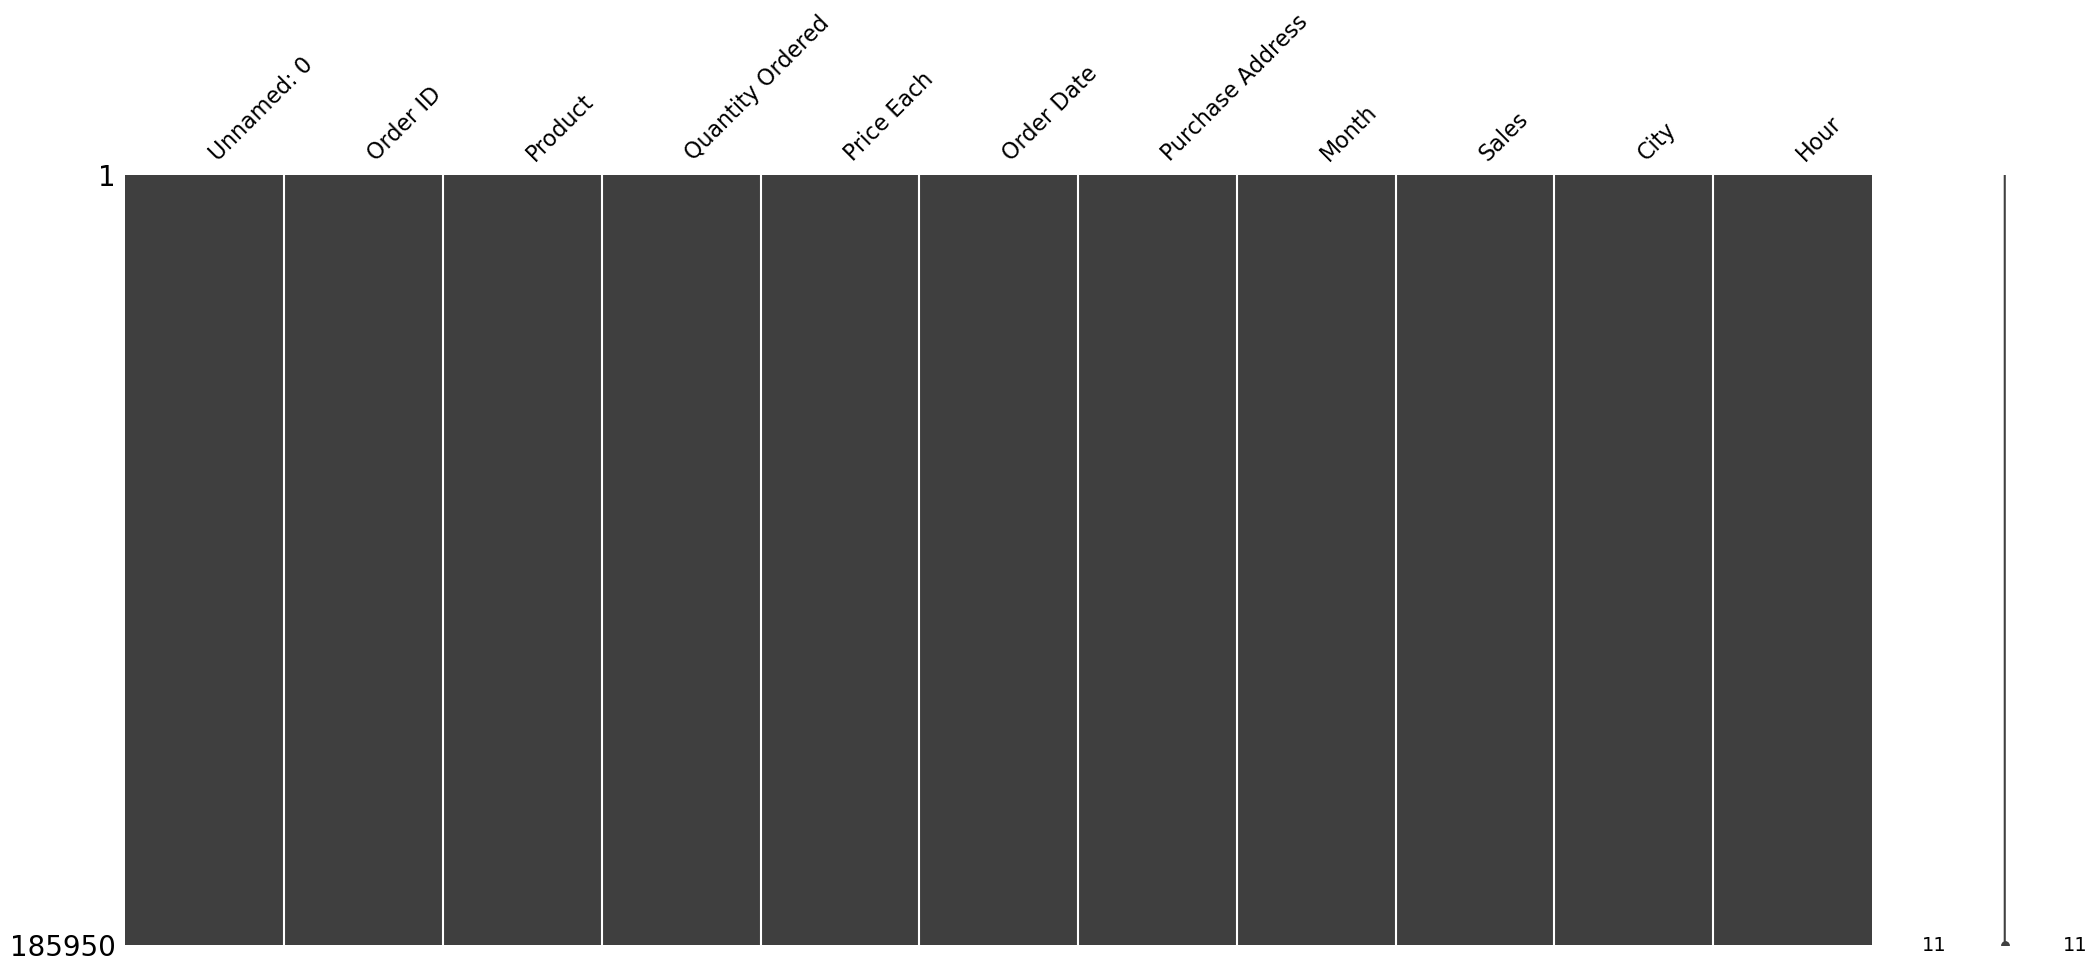

In [9]:
msno.matrix(sales_df)

## Dimension Tables

### Time Dimension Table

In [10]:
# Drop duplicates
time_dim_df = sales_df[['Order ID', 'Order Date']].drop_duplicates()
time_dim_df.shape

(178437, 2)

In [11]:
# Add granularity 
# Convert 'Order Date' column to datetime
time_dim_df['Order Date'] = pd.to_datetime(time_dim_df['Order Date'])

# Extract year and month
time_dim_df['Year'] = pd.to_datetime(time_dim_df['Order Date']).dt.year
time_dim_df['Quarter'] = pd.to_datetime(time_dim_df['Order Date']).dt.quarter
time_dim_df['Month'] = pd.to_datetime(time_dim_df['Order Date']).dt.month
time_dim_df['Day'] = pd.to_datetime(time_dim_df['Order Date']).dt.day
time_dim_df['Hour'] = pd.to_datetime(time_dim_df['Order Date']).dt.hour

# Display dataframe head 
time_dim_df.head()

,Order ID,Order Date,Year,Quarter,Month,Day,Hour
0,295665,2019-12-30 00:01:00,2019,4,12,30,0
1,295666,2019-12-29 07:03:00,2019,4,12,29,7
2,295667,2019-12-12 18:21:00,2019,4,12,12,18
3,295668,2019-12-22 15:13:00,2019,4,12,22,15
4,295669,2019-12-18 12:38:00,2019,4,12,18,12


In [12]:
# Data type check
time_dim_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178437 entries, 0 to 185949
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Order ID    178437 non-null  int64         
 1   Order Date  178437 non-null  datetime64[ns]
 2   Year        178437 non-null  int64         
 3   Quarter     178437 non-null  int64         
 4   Month       178437 non-null  int64         
 5   Day         178437 non-null  int64         
 6   Hour        178437 non-null  int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 10.9 MB


In [13]:
# Save to csv
time_dim_df.to_csv('./star_schema_data/time_dim.csv', index=False)

### Product Dimension Table

In [14]:
# Drop duplicates
product_dim_df = sales_df[['Product', 'Price Each']].drop_duplicates().sort_values(by=['Product'], ascending=True)
product_dim_df.shape

(19, 2)

In [15]:
# Add surrogate key
product_dim_df.sort_values(by=['Product'], ascending=True) 
product_dim_df.reset_index(inplace=True) 
product_dim_df['Product ID'] = product_dim_df.index 
product_dim_df = product_dim_df.merge(product_addon_df, how='left', on='Product')
product_dim_df = product_dim_df[['Product ID', 'Product', 'Category', 'Subcategory', 'Price Each', 'Cost Each']] 
product_dim_df.head() 

,Product ID,Product,Category,Subcategory,Price Each,Cost Each
0,0,20in Monitor,"Computer, Tablets & Gaming",Monitors,109.99,57.19
1,1,27in 4K Gaming Monitor,"Computer, Tablets & Gaming",Gaming Monitors,389.99,202.79
2,2,27in FHD Monitor,"Computer, Tablets & Gaming",Monitors,149.99,79.49
3,3,34in Ultrawide Monitor,"Computer, Tablets & Gaming",Monitors,379.99,193.79
4,4,AA Batteries (4-pack),"Computer, Tablets & Gaming",Batteries,3.84,2.15


In [16]:
# Data type check
product_dim_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 18
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Product ID   19 non-null     int64  
 1   Product      19 non-null     object 
 2   Category     19 non-null     object 
 3   Subcategory  19 non-null     object 
 4   Price Each   19 non-null     float64
 5   Cost Each    19 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.0+ KB


In [17]:
# Save to csv
product_dim_df.to_csv('./star_schema_data/product_dim.csv', index=False)

### Purchase Address Dimension Table

In [18]:
# Drop duplicates
purchaseaddress_dim_df = sales_df[['Purchase Address']].drop_duplicates()
purchaseaddress_dim_df.shape

(140787, 1)

In [19]:
# Add granularity 
purchaseaddress_dim_df['Street'] = purchaseaddress_dim_df['Purchase Address'].map(lambda row: row.split(',')[0])
purchaseaddress_dim_df['City'] = purchaseaddress_dim_df['Purchase Address'].map(lambda row: row.split(',')[1])
purchaseaddress_dim_df['State'] = purchaseaddress_dim_df['Purchase Address'].map(lambda row: row.split(',')[2].split(' ')[1])
purchaseaddress_dim_df['Zip Code'] = purchaseaddress_dim_df['Purchase Address'].map(lambda row: row.split(',')[2].split(' ')[2])

In [20]:
# Add surrogate key
purchaseaddress_dim_df.sort_values(by=['State', 'City', 'Zip Code', 'Street'], ascending=True)
purchaseaddress_dim_df.reset_index(inplace=True)
purchaseaddress_dim_df['Purchase Address ID'] = purchaseaddress_dim_df.index
purchaseaddress_dim_df = purchaseaddress_dim_df.merge(purchaseaddress_addon_df, how='left', on='City')
purchaseaddress_dim_df = purchaseaddress_dim_df[['Purchase Address ID', 'Purchase Address', 'Street', 'City', 'State', 'Zip Code', 'Region']]
purchaseaddress_dim_df.head()

,Purchase Address ID,Purchase Address,Street,City,State,Zip Code,Region
0,0,"136 Church St, New York City, NY 10001",136 Church St,New York City,NY,10001,Northeast
1,1,"562 2nd St, New York City, NY 10001",562 2nd St,New York City,NY,10001,Northeast
2,2,"277 Main St, New York City, NY 10001",277 Main St,New York City,NY,10001,Northeast
3,3,"410 6th St, San Francisco, CA 94016",410 6th St,San Francisco,CA,94016,West
4,4,"43 Hill St, Atlanta, GA 30301",43 Hill St,Atlanta,GA,30301,South


In [21]:
# Check data type. 
purchaseaddress_dim_df['Zip Code'] = purchaseaddress_dim_df['Zip Code'].astype(int)

# Data type check
purchaseaddress_dim_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140787 entries, 0 to 140786
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Purchase Address ID  140787 non-null  int64 
 1   Purchase Address     140787 non-null  object
 2   Street               140787 non-null  object
 3   City                 140787 non-null  object
 4   State                140787 non-null  object
 5   Zip Code             140787 non-null  int64 
 6   Region               140787 non-null  object
dtypes: int64(2), object(5)
memory usage: 8.6+ MB


In [22]:
# Save to csv
purchaseaddress_dim_df.to_csv('./star_schema_data/purchaseaddress_dim.csv', index=False)

## Fact Table

In [23]:
# Drop duplicates
sales_fact_df = sales_df.drop_duplicates()
sales_fact_df.shape

(185950, 11)

In [24]:
# Update with the respective ID
sales_fact_df = sales_fact_df.merge(time_dim_df, on=['Order ID', 'Order Date'], how='left')
sales_fact_df = sales_fact_df.merge(product_dim_df, on=['Product', 'Price Each'], how='left')
sales_fact_df = sales_fact_df.merge(purchaseaddress_dim_df, on=['Purchase Address'], how='left')
sales_fact_df = sales_fact_df[['Order ID', 'Product ID', 'Purchase Address ID', 'Quantity Ordered']] 
sales_fact_df.shape

(185950, 4)

In [25]:
# Display head 
sales_fact_df.head() 

,Order ID,Product ID,Purchase Address ID,Quantity Ordered
0,295665,13,0,1
1,295666,11,1,1
2,295667,15,2,1
3,295668,2,3,1
4,295669,15,4,1


In [26]:
# Data type check
sales_fact_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185950 entries, 0 to 185949
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   Order ID             185950 non-null  int64
 1   Product ID           185950 non-null  int64
 2   Purchase Address ID  185950 non-null  int64
 3   Quantity Ordered     185950 non-null  int64
dtypes: int64(4)
memory usage: 7.1 MB


In [27]:
# Save to csv
sales_fact_df.to_csv('./star_schema_data/sales_fact.csv', index=False)